# 1D Convolutional Neural Network

In [ ]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from collections import defaultdict
 
import matplotlib.pyplot as plt
 
import sklearn
from sklearn.model_selection import train_test_split
 
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

In [ ]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.4.1


## Load Data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/naufalhilmiaji/id_cnn-text-emotion-classification/main/datasets/df_preprocessed.csv')
df.drop('Unnamed: 0', 1, inplace=True)

In [ ]:
def remove_unnecesary_strings(data, word):
    data = data.str.replace(' '+str(word), '')
    data = data.str.replace(str(word)+' ', '')
    data = data.str.replace(' '+str(word)+' ', '')
    return data

df['cleaned_tweets'] = remove_unnecesary_strings(df['cleaned_tweets'], 'username')
df['cleaned_tweets'] = remove_unnecesary_strings(df['cleaned_tweets'], 'url')
df['cleaned_tweets'] = remove_unnecesary_strings(df['cleaned_tweets'], 'sensitive-no')

In [ ]:
df['label'].value_counts()

anger      1101
happy      1017
sadness     997
fear        649
love        637
Name: label, dtype: int64

In [ ]:
label_and_code = dict(zip(df['label_code'].unique(), df['label'].unique()))
label_and_code

{0: 'anger', 1: 'happy', 2: 'sadness', 3: 'love', 4: 'fear'}

## Define Needed Parameters

In [ ]:
sentences = [row.split() for row in df['cleaned_tweets']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1

In [ ]:
len(word_freq)

14648

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['dan', 'yg', 'yang', 'di', 'aku', 'ini', 'itu', 'ada', 'sama', 'ya']

In [ ]:
print('The Amount of Vocabularies: {}'.format(len(word_freq)))
print('Maximum Tweet Length: {}'.format(max(df['tweets_length'])))

The Amount of Vocabularies: 14648
Maximum Tweet Length: 83


In [ ]:
# decreased_vocab = sorted(word_freq, key=word_freq.get, reverse=True)[:2000]

__vocab_size__: using 14650 vocabularies for input dimension. <br>
__embedding_dim__: 300 for output dimension. <br>
__max_length__: The maximum length of tweets is 83, so we take 83 for the maximum input length.<br>

In [ ]:
temp = []
for i in range(len(df)):
  temp.append(df['tweets_length'][i])

sum(temp)/len(df)

28.898432174505793

In [ ]:
vocab_size = len(word_freq)
embedding_dim = 128
max_length = max(df['tweets_length'])

### Data Split

In [ ]:
train_set, validation_set = train_test_split(df, train_size=0.7, random_state=42)
print('Training Set: {} rows\nValidation Set: {} rows'.format(len(train_set), len(validation_set)))

Training Set: 3080 rows
Validation Set: 1321 rows


### Word Tokenizer

In [ ]:
# tokenize tweets
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_set["cleaned_tweets"])
word_index = tokenizer.word_index

### Tweets to Sequences
Transform text from tweets to Tensorflow's sequences.

In [ ]:
def encode(text):
    return tokenizer.texts_to_sequences(text)
 
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
 
def decode(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return words

#### Train Data

In [ ]:
train_sequences = encode(train_set["cleaned_tweets"])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')

In [ ]:
print('before pad_sequences: ',len(train_sequences[0]))
print('after pad_sequences: ',len(train_padded[0]))
 
print('before pad_sequences: ',len(train_sequences[1]))
print('after pad_sequences: ',len(train_padded[1]))
 
print('before pad_sequences: ',len(train_sequences[10]))
print('after pad_sequences: ',len(train_padded[10]))

before pad_sequences:  19
after pad_sequences:  83
before pad_sequences:  16
after pad_sequences:  83
before pad_sequences:  38
after pad_sequences:  83


In [ ]:
print(train_padded.shape)

(3080, 83)


#### Test

In [ ]:
validation_sequences = encode(validation_set['cleaned_tweets'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding='post')
 
print(validation_padded.shape)

(1321, 83)


### Encode Labels to Categorical

In [ ]:
training_label_enc = to_categorical(train_set['label_code'])
validation_label_enc = to_categorical(validation_set['label_code'])

In [ ]:
train_padded.shape, validation_padded.shape, training_label_enc.shape, validation_label_enc.shape

((3080, 83), (1321, 83), (3080, 5), (1321, 5))

## 1D CNN Architecture
Creating model for 1D Convolutional Neural Network

In [ ]:
def eval_model(x, y, model):
    loss, accuracy = model.evaluate(x, y, verbose=False)
    return loss, accuracy

In [ ]:
def create_model(vocab, dim, length): # BEST MODEL
    model = Sequential()
    model.add(Embedding(vocab+1, dim, input_length=length))
    model.add(Conv1D(128, 5, activation='relu',
                     kernel_regularizer=regularizers.l2(0.0001),
                     bias_regularizer=regularizers.l2(0.0001)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(100, activation='relu',
                     kernel_regularizer=regularizers.l2(0.0001),
                     bias_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))               
    return model

In [ ]:
model_cnn = create_model(vocab_size, embedding_dim, max_length)
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 83, 128)           1875072   
_________________________________________________________________
conv1d (Conv1D)              (None, 79, 128)           82048     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 1,970,525
Trainable params: 1,970,525
Non-trainable params: 0
______________________________________________

### Model Visualization

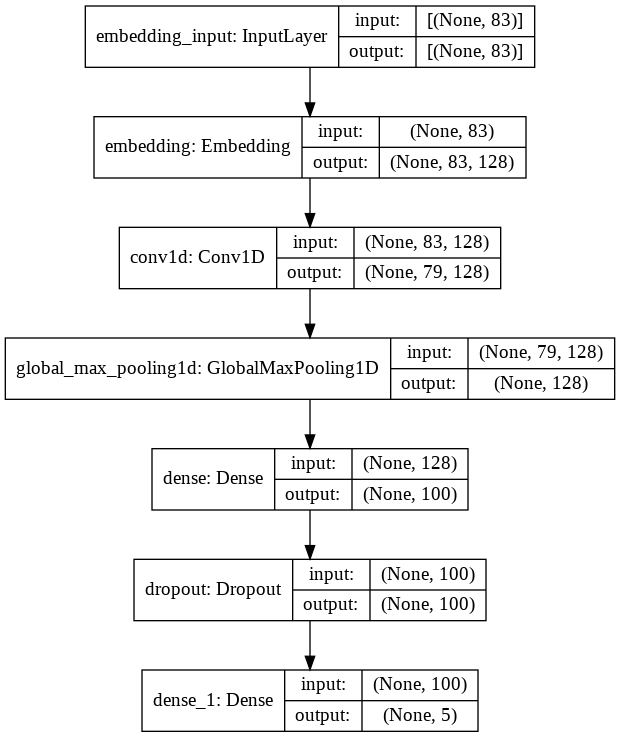

In [ ]:
plot_model(model_cnn, to_file='visualize_model.png', show_shapes=True, show_layer_names=True)

### Model Training

In [ ]:
adam = tf.optimizers.Adam(learning_rate=0.0003)
model_cnn.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
es_callbacks = [EarlyStopping(monitor='val_loss'),
             ModelCheckpoint(filepath='models/model_checkpoint_cnn.h5', 
                             monitor='val_accuracy', save_best_only=True, 
                             mode='max')]
 
 
history = model_cnn.fit(train_padded,
          training_label_enc,
          epochs=100,
          validation_data=(validation_padded, validation_label_enc),
          callbacks=[es_callbacks])

Epoch 1/100
97/97 [==============================] - 8s 75ms/step - loss: 1.6316 - accuracy: 0.2166 - val_loss: 1.5976 - val_accuracy: 0.2755
Epoch 2/100
97/97 [==============================] - 6s 67ms/step - loss: 1.5845 - accuracy: 0.3061 - val_loss: 1.5692 - val_accuracy: 0.3497
Epoch 3/100
97/97 [==============================] - 6s 67ms/step - loss: 1.5015 - accuracy: 0.4801 - val_loss: 1.4116 - val_accuracy: 0.5231
Epoch 4/100
97/97 [==============================] - 7s 67ms/step - loss: 1.2509 - accuracy: 0.6541 - val_loss: 1.2226 - val_accuracy: 0.5889
Epoch 5/100
97/97 [==============================] - 6s 67ms/step - loss: 0.9608 - accuracy: 0.7612 - val_loss: 1.1075 - val_accuracy: 0.6207
Epoch 6/100
97/97 [==============================] - 6s 67ms/step - loss: 0.6595 - accuracy: 0.8568 - val_loss: 1.0273 - val_accuracy: 0.6412
Epoch 7/100
97/97 [==============================] - 6s 67ms/step - loss: 0.4448 - accuracy: 0.9105 - val_loss: 0.9892 - val_accuracy: 0.6480
Epoch 

In [ ]:
# model_cnn.save('model_cnn.h5')

### Model Evaluation

#### Accuracy and Loss Plot

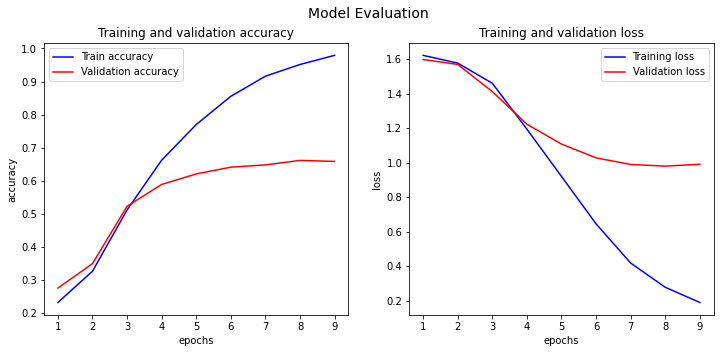

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, accuracy, 'b', label='Train accuracy')
plt.plot(x, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.suptitle('Model Evaluation', fontsize=14)
plt.savefig('cnn_graph.png')

#### Model Architecture Evaluation (Train and Validation Data)

In [ ]:
loss_train_best, accuracy_train_best = eval_model(train_padded, training_label_enc, model_cnn)
loss_test_best, accuracy_test_best = eval_model(validation_padded, validation_label_enc, model_cnn)

In [ ]:
print('Train [{}][{}]'.format(accuracy_train_best, loss_train_best))
print('Test [{}][{}]'.format(accuracy_test_best, loss_test_best))

Train [0.9948052167892456][0.11007221043109894]
Test [0.6585919857025146][0.9903292059898376]


In [ ]:
def encode_predict(text):
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, maxlen=max_length, padding='post')
    return text

In [ ]:
df_encoded = encode_predict(df['cleaned_tweets'])
result_classes = np.argmax(model_cnn.predict(df_encoded), axis=-1)

### Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [ ]:
(unique, counts) = np.unique(result_classes, return_counts=True)
 
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 1108],
       [   1, 1018],
       [   2, 1003],
       [   3,  657],
       [   4,  615]])

In [ ]:
ground_truth = np.asarray(df['label_code'])

In [ ]:
print(classification_report(ground_truth, result_classes))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1101
           1       0.89      0.89      0.89      1017
           2       0.86      0.86      0.86       997
           3       0.90      0.93      0.92       637
           4       0.95      0.90      0.93       649

    accuracy                           0.89      4401
   macro avg       0.90      0.90      0.90      4401
weighted avg       0.89      0.89      0.89      4401



In [ ]:
label_and_code

{0: 'anger', 1: 'happy', 2: 'sadness', 3: 'love', 4: 'fear'}

In [ ]:
import seaborn as sns
 
colormap = sns.color_palette('Blues')

In [ ]:
xtick = []
for i in range(len(result_classes)):
  if result_classes[i] == 0:
    xtick.append('anger')
  elif result_classes[i] == 1:
    xtick.append('happy')
  elif result_classes[i] == 2:
    xtick.append('sadness')
  elif result_classes[i] == 3:
    xtick.append('love')
  else:
    xtick.append('fear')

In [ ]:
classes = list(label_and_code.values())
classes

['anger', 'happy', 'sadness', 'love', 'fear']

In [ ]:
confusion_matrix(ground_truth, result_classes)

array([[996,  40,  43,   8,  14],
       [ 33, 901,  58,  18,   7],
       [ 51,  50, 858,  31,   7],
       [  5,  17,  19, 594,   2],
       [ 23,  10,  25,   6, 585]])

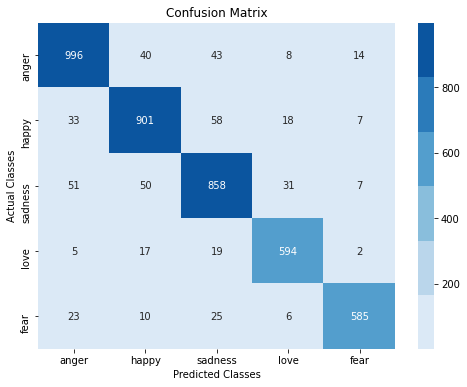

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(confusion_matrix(ground_truth, result_classes), annot = True, cmap=colormap, fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set(xlabel='Predicted Classes', ylabel='Actual Classes')
ax.figure.savefig('confusion_matrix.png')

In [ ]:
df_result = pd.DataFrame(list(zip(df['cleaned_tweets'], df['label_code'], result_classes)),
               columns =['tweets', 'class', 'predicted'])
df_result

,tweets,class,predicted
0,soal jln jatibaru polisi tdk bs gertak gubernu...,0,0
1,sama cewe lho kayak harus bisa lebih rasain la...,0,0
2,kepingin gudeg mbarek bu hj amad foto dari goo...,1,1
3,jln jatibaru bagi dari wilayah tn abang atur w...,0,0
4,sharing alam aja kemarin jam 18 00 batalin tik...,1,1
...,...,...,...
4396,tahu kamu bahwa saat itu papa mejam mata dan t...,3,3
4397,sulit tetap calon wapresnya jokowi di pilpres ...,4,4
4398,5 masa depan nggak jelas lha iya gimana mau je...,0,0
4399,dulu beneran ada mahasiswa teknik ui nembak pa...,1,3


In [ ]:
label_and_code

{0: 'anger', 1: 'happy', 2: 'sadness', 3: 'love', 4: 'fear'}